In [1]:
import astropy.units as u
import numpy as np
from astroquery.simbad import Simbad
import astropy.coordinates as coord

from astropy.io import ascii
from astropy.io import fits
import os.path
# 
import elk
from elk.ensemble import EnsembleLC
from elk.lightcurve import BasicLightcurve

from astropy.table import Table, join, MaskedColumn, vstack, Column
from matplotlib import pyplot as plt
import glob

import numpy as np

from astroML.datasets import fetch_sdss_galaxy_images, fetch_LINEAR_sample, fetch_LINEAR_geneva
from astroML.utils import split_samples

import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.gaussian_process import GaussianProcessRegressor

from tqdm import tqdm
from scipy.special import entr

from astropy.table import Column
from scipy.stats import entropy as entr
import time
import sys

In [2]:
f = open('cluster_names.txt', 'r')
names = f.readlines()
cnames = []
for i in names:
    t = i.split('\n')[0]
    cnames.append(t)

In [3]:
# filenames = glob.glob(path + '*.fits')

In [4]:
def get_cluster_data(name):
    cluster_sumary_data_path= '/uufs/chpc.utah.edu/common/home/astro/zasowski/sinha/tess_data/data/cluster_summary_files/'
    cluster_files = glob.glob(cluster_sumary_data_path + '{}*.fits'.format(name))
    return cluster_files

files = get_cluster_data(cnames[2])

In [5]:
data = Table.read(files[0],hdu=1)

stats= ['rms','std','MAD','sigmaG','von_neumann_ratio','J_Stetson','max_power','freq_at_max_power','ratio_of_power_at_high_v_low_freq',
       'FAP','max_autocorrelation','time_of_max_autocorrelation','SumLSP_10_7_Day_Power','SumLSP_7_4_Day_Power','SumLSP_4_1_Day_Power','SumLSP_1_p5_Day_Power']

In [6]:
summary_table = Table()
summary_table['filenames'] = cnames

In [7]:
names = []
n_resamples = []
loc = []
age = []

for i in summary_table['filenames']:
    files = get_cluster_data(i)
    if len(files) == 0:
        names.append(np.nan)
        n_resamples.append(0)
        loc.append(np.nan)
        age.append(np.nan)
    else:
        data = Table.read(files[0],hdu=1)
        names.append(data[0]['name'])
        n_resamples.append(len(data['name']))
        loc.append(data[0]['LOC'])
        age.append(data[0]['AGE'])       
        

In [8]:
summary_table['name'] = names
summary_table['n_resamples'] = n_resamples
summary_table['location'] = loc
summary_table['age'] = age

In [9]:
summary_table= summary_table[summary_table['n_resamples'] > 0]

In [10]:
def get_stat_percentile(table, colname,percent):
    col = []
    for i in table['filenames']:
        files = get_cluster_data(i)
        data = Table.read(files[0],hdu=1)
        val = np.percentile(data[colname],percent)
        col.append(val)
    return col
        

In [11]:
percentiles = [2.5,5,25,34,50,68,75,95,97.5]

for i in stats:
    for j in percentiles:
        final_colname = '{}_{}'.format(i,j)
        col = get_stat_percentile(summary_table, i,j)
        summary_table[final_colname] = col
    print('Done: {}'.format(i))

Done: rms
Done: std
Done: MAD
Done: sigmaG
Done: von_neumann_ratio
Done: J_Stetson
Done: max_power
Done: freq_at_max_power
Done: ratio_of_power_at_high_v_low_freq
Done: FAP
Done: max_autocorrelation
Done: time_of_max_autocorrelation
Done: SumLSP_10_7_Day_Power
Done: SumLSP_7_4_Day_Power
Done: SumLSP_4_1_Day_Power
Done: SumLSP_1_p5_Day_Power


In [13]:
summary_table.write('corrected_cluster_summary_stats.fits',overwrite=True)

In [14]:
summary_table

filenames,name,n_resamples,location,age,rms_2.5,rms_5,rms_25,rms_34,rms_50,rms_68,rms_75,rms_95,rms_97.5,std_2.5,std_5,std_25,std_34,std_50,std_68,std_75,std_95,std_97.5,MAD_2.5,MAD_5,MAD_25,MAD_34,MAD_50,MAD_68,MAD_75,MAD_95,MAD_97.5,sigmaG_2.5,sigmaG_5,sigmaG_25,sigmaG_34,sigmaG_50,sigmaG_68,sigmaG_75,sigmaG_95,sigmaG_97.5,von_neumann_ratio_2.5,von_neumann_ratio_5,von_neumann_ratio_25,von_neumann_ratio_34,von_neumann_ratio_50,von_neumann_ratio_68,von_neumann_ratio_75,von_neumann_ratio_95,von_neumann_ratio_97.5,J_Stetson_2.5,J_Stetson_5,J_Stetson_25,J_Stetson_34,J_Stetson_50,J_Stetson_68,J_Stetson_75,J_Stetson_95,J_Stetson_97.5,max_power_2.5,max_power_5,max_power_25,max_power_34,max_power_50,max_power_68,max_power_75,max_power_95,max_power_97.5,freq_at_max_power_2.5,freq_at_max_power_5,freq_at_max_power_25,freq_at_max_power_34,freq_at_max_power_50,freq_at_max_power_68,freq_at_max_power_75,freq_at_max_power_95,freq_at_max_power_97.5,ratio_of_power_at_high_v_low_freq_2.5,ratio_of_power_at_high_v_low_freq_5,ratio_of_power_at_high_v_low_freq_25,ratio_of_power_at_high_v_low_freq_34,ratio_of_power_at_high_v_low_freq_50,ratio_of_power_at_high_v_low_freq_68,ratio_of_power_at_high_v_low_freq_75,ratio_of_power_at_high_v_low_freq_95,ratio_of_power_at_high_v_low_freq_97.5,FAP_2.5,FAP_5,FAP_25,FAP_34,FAP_50,FAP_68,FAP_75,FAP_95,FAP_97.5,max_autocorrelation_2.5,max_autocorrelation_5,max_autocorrelation_25,max_autocorrelation_34,max_autocorrelation_50,max_autocorrelation_68,max_autocorrelation_75,max_autocorrelation_95,max_autocorrelation_97.5,time_of_max_autocorrelation_2.5,time_of_max_autocorrelation_5,time_of_max_autocorrelation_25,time_of_max_autocorrelation_34,time_of_max_autocorrelation_50,time_of_max_autocorrelation_68,time_of_max_autocorrelation_75,time_of_max_autocorrelation_95,time_of_max_autocorrelation_97.5,SumLSP_10_7_Day_Power_2.5,SumLSP_10_7_Day_Power_5,SumLSP_10_7_Day_Power_25,SumLSP_10_7_Day_Power_34,SumLSP_10_7_Day_Power_50,SumLSP_10_7_Day_Power_68,SumLSP_10_7_Day_Power_75,SumLSP_10_7_Day_Power_95,SumLSP_10_7_Day_Power_97.5,SumLSP_7_4_Day_Power_2.5,SumLSP_7_4_Day_Power_5,SumLSP_7_4_Day_Power_25,SumLSP_7_4_Day_Power_34,SumLSP_7_4_Day_Power_50,SumLSP_7_4_Day_Power_68,SumLSP_7_4_Day_Power_75,SumLSP_7_4_Day_Power_95,SumLSP_7_4_Day_Power_97.5,SumLSP_4_1_Day_Power_2.5,SumLSP_4_1_Day_Power_5,SumLSP_4_1_Day_Power_25,SumLSP_4_1_Day_Power_34,SumLSP_4_1_Day_Power_50,SumLSP_4_1_Day_Power_68,SumLSP_4_1_Day_Power_75,SumLSP_4_1_Day_Power_95,SumLSP_4_1_Day_Power_97.5,SumLSP_1_p5_Day_Power_2.5,SumLSP_1_p5_Day_Power_5,SumLSP_1_p5_Day_Power_25,SumLSP_1_p5_Day_Power_34,SumLSP_1_p5_Day_Power_50,SumLSP_1_p5_Day_Power_68,SumLSP_1_p5_Day_Power_75,SumLSP_1_p5_Day_Power_95,SumLSP_1_p5_Day_Power_97.5
str47,str32,int64,str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
hlsp_elk_tess_ffi_ascc-116_tess_v1_llc,ASCC 116,15,MW,7.95,0.11922095350424355,0.11922095

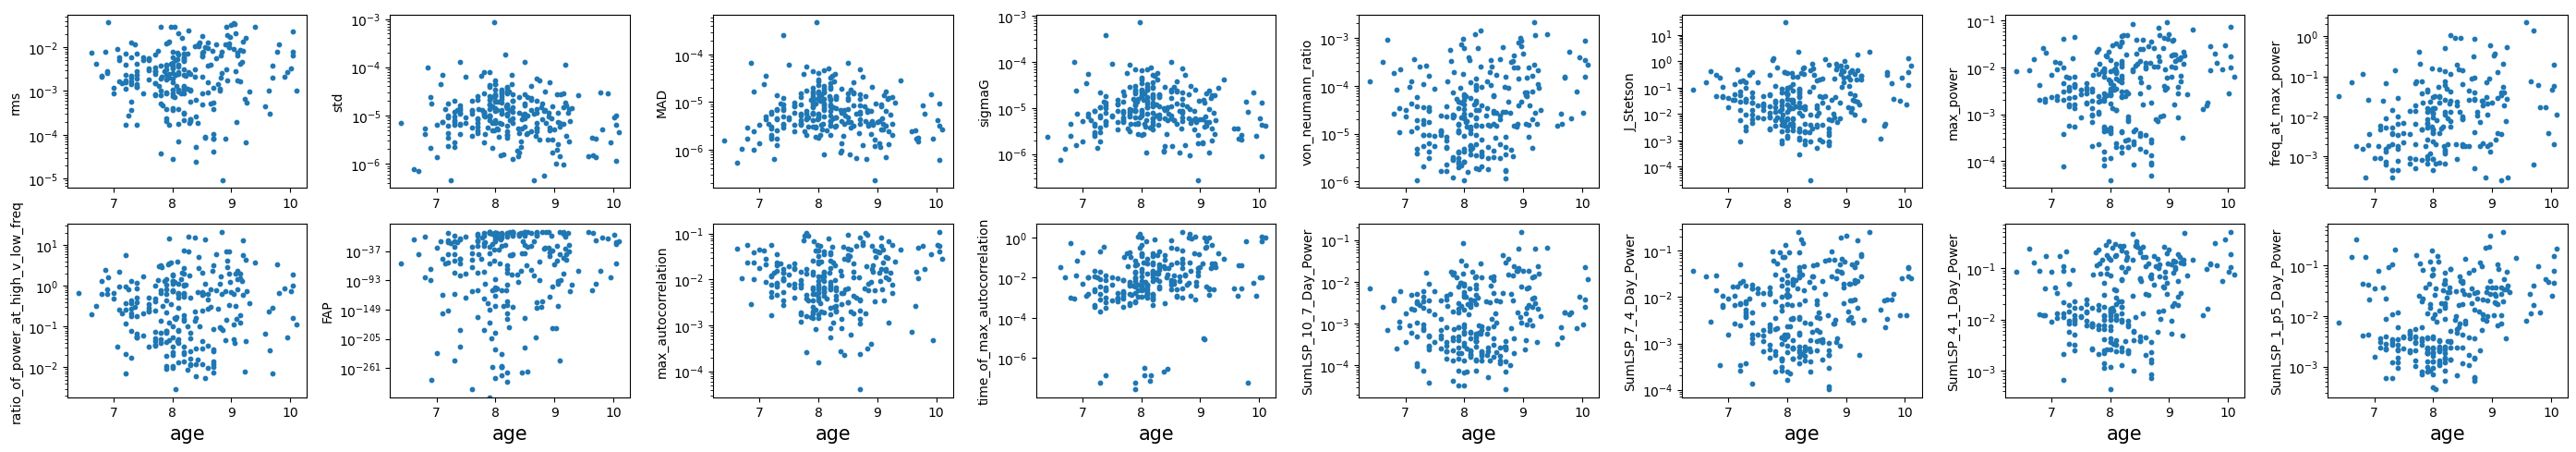

In [26]:
row = 0
col = 0
fig,ax = plt.subplots(2,8,figsize=(28,5))
for i in stats:
    ax[row][col].scatter(summary_table['age'],(summary_table['{}_68'.format(i)] - summary_table['{}_34'.format(i)]) / np.sqrt(summary_table['n_resamples']),s=10)
    # ax[col].axhline(y=0.3)
    ax[row][col].set_yscale('log')
    ax[row][col].set_ylabel(i,fontsize=10)
    ax[1][col].set_xlabel('age',fontsize=15)
    col +=1

    if col == 8:
        row +=1
        col = 0
plt.tight_layout()

In [27]:
rms_spread = (summary_table['rms_68'] - summary_table['rms_34']) / np.sqrt(summary_table['n_resamples'])
truth = rms_spread < np.nanmedian(summary_table['rms_68']) - np.nanmedian(summary_table['rms_34'])

for i in stats:
    spread = (summary_table['{}_68'.format(i)] - summary_table['{}_34'.format(i)]) / np.sqrt(summary_table['n_resamples'])

    med = np.nanmedian(summary_table['{}_68'.format(i)]- summary_table['{}_34'.format(i)])/np.sqrt(summary_table['n_resamples'])
    std = np.nanstd(summary_table['{}_68'.format(i)]- summary_table['{}_34'.format(i)])/np.sqrt(summary_table['n_resamples'])
    
    col_truth = spread < med + 2*std
    truth = truth & col_truth


summary_table['gold'] = truth

# bad_clusters_charlie = ['NGC1704','[SL63] 410','NGC1932',
#                         '[SL63] 106','NGC 129','IC 2581',
#                         '[SL63] 763','BSDL1674','NGC2000']

# bad_cluster_truth = np.isin(list(cluster_summary_stats['summary_fname']),bad_clusters_charlie)
# summary_table['gold'] = summary_table['gold']

In [28]:
summary_table

filenames,name,n_resamples,location,age,rms_2.5,rms_5,rms_25,rms_34,rms_50,rms_68,rms_75,rms_95,rms_97.5,std_2.5,std_5,std_25,std_34,std_50,std_68,std_75,std_95,std_97.5,MAD_2.5,MAD_5,MAD_25,MAD_34,MAD_50,MAD_68,MAD_75,MAD_95,MAD_97.5,sigmaG_2.5,sigmaG_5,sigmaG_25,sigmaG_34,sigmaG_50,sigmaG_68,sigmaG_75,sigmaG_95,sigmaG_97.5,von_neumann_ratio_2.5,von_neumann_ratio_5,von_neumann_ratio_25,von_neumann_ratio_34,von_neumann_ratio_50,von_neumann_ratio_68,von_neumann_ratio_75,von_neumann_ratio_95,von_neumann_ratio_97.5,J_Stetson_2.5,J_Stetson_5,J_Stetson_25,J_Stetson_34,J_Stetson_50,J_Stetson_68,J_Stetson_75,J_Stetson_95,J_Stetson_97.5,max_power_2.5,max_power_5,max_power_25,max_power_34,max_power_50,max_power_68,max_power_75,max_power_95,max_power_97.5,freq_at_max_power_2.5,freq_at_max_power_5,freq_at_max_power_25,freq_at_max_power_34,freq_at_max_power_50,freq_at_max_power_68,freq_at_max_power_75,freq_at_max_power_95,freq_at_max_power_97.5,ratio_of_power_at_high_v_low_freq_2.5,ratio_of_power_at_high_v_low_freq_5,ratio_of_power_at_high_v_low_freq_25,ratio_of_power_at_high_v_low_freq_34,ratio_of_power_at_high_v_low_freq_50,ratio_of_power_at_high_v_low_freq_68,ratio_of_power_at_high_v_low_freq_75,ratio_of_power_at_high_v_low_freq_95,ratio_of_power_at_high_v_low_freq_97.5,FAP_2.5,FAP_5,FAP_25,FAP_34,FAP_50,FAP_68,FAP_75,FAP_95,FAP_97.5,max_autocorrelation_2.5,max_autocorrelation_5,max_autocorrelation_25,max_autocorrelation_34,max_autocorrelation_50,max_autocorrelation_68,max_autocorrelation_75,max_autocorrelation_95,max_autocorrelation_97.5,time_of_max_autocorrelation_2.5,time_of_max_autocorrelation_5,time_of_max_autocorrelation_25,time_of_max_autocorrelation_34,time_of_max_autocorrelation_50,time_of_max_autocorrelation_68,time_of_max_autocorrelation_75,time_of_max_autocorrelation_95,time_of_max_autocorrelation_97.5,SumLSP_10_7_Day_Power_2.5,SumLSP_10_7_Day_Power_5,SumLSP_10_7_Day_Power_25,SumLSP_10_7_Day_Power_34,SumLSP_10_7_Day_Power_50,SumLSP_10_7_Day_Power_68,SumLSP_10_7_Day_Power_75,SumLSP_10_7_Day_Power_95,SumLSP_10_7_Day_Power_97.5,SumLSP_7_4_Day_Power_2.5,SumLSP_7_4_Day_Power_5,SumLSP_7_4_Day_Power_25,SumLSP_7_4_Day_Power_34,SumLSP_7_4_Day_Power_50,SumLSP_7_4_Day_Power_68,SumLSP_7_4_Day_Power_75,SumLSP_7_4_Day_Power_95,SumLSP_7_4_Day_Power_97.5,SumLSP_4_1_Day_Power_2.5,SumLSP_4_1_Day_Power_5,SumLSP_4_1_Day_Power_25,SumLSP_4_1_Day_Power_34,SumLSP_4_1_Day_Power_50,SumLSP_4_1_Day_Power_68,SumLSP_4_1_Day_Power_75,SumLSP_4_1_Day_Power_95,SumLSP_4_1_Day_Power_97.5,SumLSP_1_p5_Day_Power_2.5,SumLSP_1_p5_Day_Power_5,SumLSP_1_p5_Day_Power_25,SumLSP_1_p5_Day_Power_34,SumLSP_1_p5_Day_Power_50,SumLSP_1_p5_Day_Power_68,SumLSP_1_p5_Day_Power_75,SumLSP_1_p5_Day_Power_95,SumLSP_1_p5_Day_Power_97.5,gold
str47,str32,int64,str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool
hlsp_elk_tess_ffi_ascc-116_tess_v1_llc,ASCC 116,15,MW,7.95,0.11922095350424355,

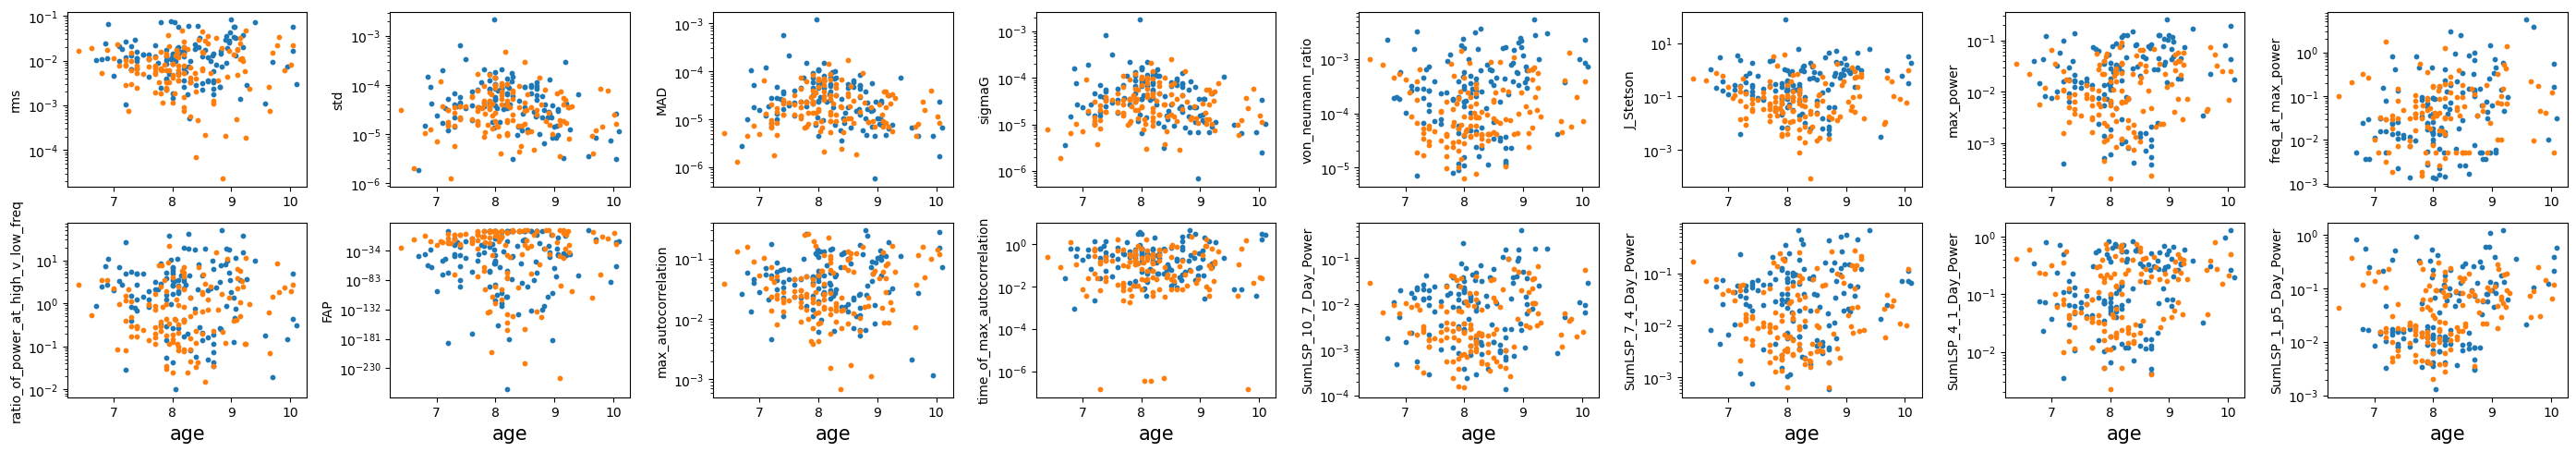

In [29]:
gold_sample = summary_table[summary_table['gold']==True]
others = summary_table[summary_table['gold']==False]
row = 0
col = 0
fig,ax = plt.subplots(2,8,figsize=(28,5))
for i in stats:
    ax[row][col].scatter(others['age'],(others['{}_95'.format(i)] - others['{}_5'.format(i)]) / np.sqrt(others['n_resamples']),s=10)
    ax[row][col].scatter(gold_sample['age'],(gold_sample['{}_95'.format(i)] - gold_sample['{}_5'.format(i)]) / np.sqrt(gold_sample['n_resamples']),s=10)
# ax[col].axhline(y=0.3)
    ax[row][col].set_yscale('log')
    ax[row][col].set_ylabel(i,fontsize=10)
    ax[1][col].set_xlabel('age',fontsize=15)
    col +=1

    if col == 8:
        row +=1
        col = 0
plt.tight_layout()

In [32]:
gold_sample.write('gold_sample_summary_stats.fits',overwrite=True)

In [35]:
temp = []
for i in gold_sample['filenames']:
    files = get_cluster_data(i)
    data = Table.read(files[0],hdu=1)
    temp.append(data)

In [36]:
resampled_gold_row_data = vstack(temp)

In [39]:
resampled_gold_row_data.write('resampled_sector_data_gold.fits',overwrite=True)

lmc_gold = resampled_gold_row_data[resampled_gold_row_data['LOC']=='LMC']
lmc_gold.write('lmc_gold_sample.fits',overwrite=True)

smc_gold = resampled_gold_row_data[resampled_gold_row_data['LOC']=='SMC']
smc_gold.write('smc_gold_sample.fits',overwrite=True)

mw_gold = resampled_gold_row_data[resampled_gold_row_data['LOC']=='MW']
mw_gold.write('mw_gold_sample.fits',overwrite=True)

In [40]:
mw_gold

name,rms,std,MAD,sigmaG,skewness,von_neumann_ratio,J_Stetson,max_power,freq_at_max_power,n_peaks,ratio_of_power_at_high_v_low_freq,FAP,max_autocorrelation,time_of_max_autocorrelation,SumLSP_10_7_Day_Power,SumLSP_7_4_Day_Power,SumLSP_4_1_Day_Power,SumLSP_1_p5_Day_Power,Entropy,FullPeriodogram,sectors,LOC,AGE
bytes16,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64[1],float64,float64,float64,float64,float64,float64[1089],bytes8,bytes3,float64
ASCC 116,0.1629838554099545,0.0006209387461506967,0.0003818188455597671,0.0005676621105904265,548805525.8794718,0.00674052288363575,23.342707146886017,0.261967301305892,0.27,7,62.95515144882746,1.0544393095109024e-57,0.19249396296966514,3.91668701171875,0.06639787636133906,0.8630108723177978,3.119955319459927,0.5425695717278529,6.8405463365386385,0.00584223375704259 .. 2.8397487734314022e-05,1,MW,7.95
ASCC 116,0.19976972570948479,0.0007037110142785061,0.0004837987093291307,0.0007166509281273368,-636011055.0325351,0.00572781029950597,25.46614158511247,0.3111422867760234,0.38000000000000006,6,39.948406884963426,6.0399069313517875e-87,0.39511909904544734,2.81243896484375,0.025663013056367215,0.31493307606939225,3.2369711678006414,0.23547669162854556,7.026426561067675,0.012956456537940867 .. 0.00024485619147236515,2,MW,7.95
ASCC 116,0.14664360278704325,0.0006795911193842874,0.0004923961884941708,0.0007288808474186777,-102743491.27035816,0.000987749200974715,9.191324576788075,0.21855894451056185,0.44000000000000006,5,92.56626978539829,0.0,0.9623476558438867,0.004629712705536804,0.07766970087049122,0.4599926963462341,2.551015470851896,0.21492833622110127,9.372969064508972,0.005365326584036537 .. 2.1742578598755085e-05,3,MW,7.95
ASCC 116,0.20155798139311246,0.0008545846556294014,0.0006007508584543464,0.0008937990951521659,1886374833.9233687,0.0010170970179177357,11.042873255831621,0.26206529073505047,0.23000000000000004,10,150.23826242493786,0.0,0.9675743014559554,0.009259152843242191,0.2362738653943266,0.8909302471338142,2.239039980783886,0.21594006054277184,9.286467367323684,0.10446994068327549 .. 3.2751829292199404e-05,4,MW,7.95
ASCC 116,0.19976972570948479,0.0006644176098164822,0.00043600613932193166,0.0006489886559705387,-143023557.4060163,0.003090723742556587,24.457888539730963,0.09637087582431031,0.39000000000000007,16,47.39617890544341,2.93639900723086e-41,0.39511909904544734,2.81243896484375,0.011783045325713653,0.26210169065162986,1.6099769833040631,0.1792710825974371,7.630946360166285,0.0035063838746664504 .. 0.00011831558949719183,"1,2",MW,7.95
ASCC 116,0.14664360278704325,0.0006465008867138608,0.0004628617049475814,0.0006876987737801218,-56613608.146618046,0.0008643704619361488,10.223814002416988,0.09876578514410747,0.43000000000000005,9,81.81707267956651,2.584370375260804e-281,0.9623476558438867,0.004629712705536804,0.030354558571666995,0.2440457960006253,1.3724329525215218,0.1817733472269944,9.449435800530376,0.0033601277310467423 .. 1.9233257192496904e-05,"1,3",MW,7.95
ASCC 116,0.20155798139311246,0.0007674148732758972,0.0005326671290734053,0.0007971225110534543,1789255839.5970156,0.0008952375907964346,12.021845080132582,0.18343455852840737,0.28,11,112.33828029598033,0.0,0.9675743014559554,0.009259152843242191,0.11706571491528016,0.4788906388319558,1.335183415921495,0.17302601722286642,9.369563583145531,0.05526289838417675 .. 2.7245266187671857e-05,"1,4",MW,7.95
ASCC 116,0.14664360278704325,0.0006597013264789445,0.0004754590113627555,0.0007043102512184605,-154672435.02023917,0.0008346616533900031,10.603663208696313,0.12147309828115922,0.38000000000000006,14,61.74243815595302,0.0,0.9623476558438867,0.004629712705536804,0.03246781309700473,0.2099746144344733,1.4260041458286628,0.11460284203518045,9.464362025335552,0.007660273913562687 .. 7.726509842373878e-05,"2,3",MW,7.95
ASCC 116,0.20155798139311246,0.0007800449631836515,0.0005446464287215402,0.0008119642294561161,1672358070.3123302,0.0008707804131944687,12.39929514785971